## 0. Goal
Prepare the MO datasets for shotgun VAE training. 
1. Chop spectrogram of syllables into sliding windows

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib.colors import ListedColormap

plt.rcParams['pdf.fonttype'] = 42 

In [28]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8]]
# what syllable to analyze, empty means all syllable with annotation
syl = ['v', 'b', 'h', 'e', 'x']
# what spectroram dataset to use, see ZZp1_makeSpec_traj_v1.ipynb
spec_suffix = 'Spectrogram1'
spec_run = 'spec_goffinet_traj_256_236'

In [5]:
# define parameters for spectrograms
X_SHAPE = [128, 128]
p = {
    'get_spec': vae_goffinet.get_specZZ, # spectrogram maker
    'max_dur': 1e9, # maximum syllable duration
    'min_freq': 250, # minimum frequency
    'max_freq': 7500, # maximum frequency, default 7500
    'num_freq_bins': X_SHAPE[0], # hard-coded
    'num_time_bins': X_SHAPE[1], # hard-coded
    'nperseg': 256, # FFT
    'noverlap': 236, # FFT, determines window overlap when calculating spectrograms
    'spec_min_val': 1.5, # minimum log-spectrogram value
    'spec_max_val': 7, # maximum log-spectrogram value
    'fs': 20000, # audio samplerate
    'mel': False, # frequency spacing, mel or linear
    'time_stretch': False, # stretch short syllables?
    'within_syll_normalize': False, # normalize spectrogram values on a # spectrogram-by-spectrogram basis
    'pad': 0.05,  # when extracting syllables for calculating spectrograms, pad before syllable onset and after syllable onset, unit is sec
    'win_frame': 32,  # duration of the sliding window, unit is spectrogram column
    'hop_frame': 2, # how much to slide for consecutive window, unit is spectrogram column
    'win_pad': 32, # how much to include before syllable onset, unit is spectrogram column, default to one sliding window
}

## 2. Loop through birds, chop spectrograms

In [6]:
# how many spectrogram windows to generate per syllable
num_win_per = 2
# how many syllables to sample per category
num_syl = 10000

Processing for pair5RigCCU29...
Spectrogram window size (ms): 12.800
Spectrogram window hop (ms): 1.000
Sliding window 32 spec columns, slide by 2 columns, pad by 32 columns
Sliding window 32.0 ms, slide by 2.0 ms, pad by 32.0 ms
Sample 2 windows per syllable, 10000 syllables per category, total 20000 windows
traj_chop_32_2_32
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/Chop1/pair5RigCCU29.traj_chop_32_2_32.chop.h5
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/Chop1/pair5RigCCU29.traj_chop_32_2_32.chop.info.csv
(84254, 12)
Counter({'h': 27190, 'x': 24431, 'v': 23240, 'b': 5461, 'e': 3932})
v: total 23240 syllables 	 sampled 10000 syllables
b: total 5461 syllables 	 sampled 5461 syllables
h: total 27190 syllables 	 sampled 10000 syllables
e: total 3932 syllables 	 sampled 3932 syllables
x: total 24431 syllables 	 sampled 10000 syllables
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/Chop1/pair5RigCCU29.traj_chop_32_2_32.idx_rd.pkl
Sampling spec

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=48)]: Done 288 tasks      | elapsed:    1.6s
[Parallel(n_jobs=48)]: Done 612 tasks      | elapsed:    3.1s
[Parallel(n_jobs=48)]: Done 1008 tasks      | elapsed:    4.9s
[Parallel(n_jobs=48)]: Done 1476 tasks      | elapsed:    6.8s
[Parallel(n_jobs=48)]: Done 2016 tasks      | elapsed:    9.1s
[Parallel(n_jobs=48)]: Done 2628 tasks      | elapsed:   11.6s
[Parallel(n_jobs=48)]: Done 3312 tasks      | elapsed:   14.3s
[Parallel(n_jobs=48)]: Done 4068 tasks      | elapsed:   17.0s
[Parallel(n_jobs=48)]: Done 4896 tasks      | elapsed:   19.9s
[Parallel(n_jobs=48)]: Done 5796 tasks      | elapsed:   23.1s
[Parallel(n_jobs=48)]: Done 6768 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 7812 tasks      | elapsed:   29.4s
[Parallel(n_jobs=48)]: Done 8928 tasks      | elapsed:   32.6s
[Parallel(n_jobs=48)]: Done 9905 out of 1000

Sampling spectrogram windows from b...


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  67 tasks      | elapsed:    0.4s
[Parallel(n_jobs=48)]: Done 288 tasks      | elapsed:    1.4s
[Parallel(n_jobs=48)]: Done 612 tasks      | elapsed:    2.6s
[Parallel(n_jobs=48)]: Done 1008 tasks      | elapsed:    4.0s
[Parallel(n_jobs=48)]: Done 1476 tasks      | elapsed:    5.6s
[Parallel(n_jobs=48)]: Done 2016 tasks      | elapsed:    7.3s
[Parallel(n_jobs=48)]: Done 2628 tasks      | elapsed:    9.2s
[Parallel(n_jobs=48)]: Done 3312 tasks      | elapsed:   11.4s
[Parallel(n_jobs=48)]: Done 4068 tasks      | elapsed:   13.7s
[Parallel(n_jobs=48)]: Done 4896 tasks      | elapsed:   15.8s
[Parallel(n_jobs=48)]: Done 5366 out of 5461 | elapsed:   17.0s remaining:    0.3s
[Parallel(n_jobs=48)]: Done 5461 out of 5461 | elapsed:   17.2s finished


Sampling spectrogram windows from h...


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:    0.2s
[Parallel(n_jobs=48)]: Done 302 tasks      | elapsed:    0.6s
[Parallel(n_jobs=48)]: Done 936 tasks      | elapsed:    1.5s
[Parallel(n_jobs=48)]: Done 1728 tasks      | elapsed:    2.5s
[Parallel(n_jobs=48)]: Done 2664 tasks      | elapsed:    3.7s
[Parallel(n_jobs=48)]: Done 3744 tasks      | elapsed:    5.1s
[Parallel(n_jobs=48)]: Done 4968 tasks      | elapsed:    6.6s
[Parallel(n_jobs=48)]: Done 6336 tasks      | elapsed:    8.4s
[Parallel(n_jobs=48)]: Done 7848 tasks      | elapsed:   10.0s
[Parallel(n_jobs=48)]: Done 9504 tasks      | elapsed:   11.8s
[Parallel(n_jobs=48)]: Done 9905 out of 10000 | elapsed:   12.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done 10000 out of 10000 | elapsed:   12.4s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


Sampling spectrogram windows from e...


[Parallel(n_jobs=48)]: Done  67 tasks      | elapsed:    0.2s
[Parallel(n_jobs=48)]: Done 298 tasks      | elapsed:    0.5s
[Parallel(n_jobs=48)]: Done 1200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=48)]: Done 2784 tasks      | elapsed:    3.5s
[Parallel(n_jobs=48)]: Done 3932 out of 3932 | elapsed:    4.6s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:    0.2s


Sampling spectrogram windows from x...


[Parallel(n_jobs=48)]: Done 294 tasks      | elapsed:    0.5s
[Parallel(n_jobs=48)]: Done 936 tasks      | elapsed:    1.0s
[Parallel(n_jobs=48)]: Done 1728 tasks      | elapsed:    1.8s
[Parallel(n_jobs=48)]: Done 2664 tasks      | elapsed:    3.0s
[Parallel(n_jobs=48)]: Done 3744 tasks      | elapsed:    4.0s
[Parallel(n_jobs=48)]: Done 4968 tasks      | elapsed:    5.1s
[Parallel(n_jobs=48)]: Done 6336 tasks      | elapsed:    6.3s
[Parallel(n_jobs=48)]: Done 7848 tasks      | elapsed:    7.6s
[Parallel(n_jobs=48)]: Done 9504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=48)]: Done 9905 out of 10000 | elapsed:    9.5s remaining:    0.1s
[Parallel(n_jobs=48)]: Done 10000 out of 10000 | elapsed:    9.5s finished


78786 (78786, 4)


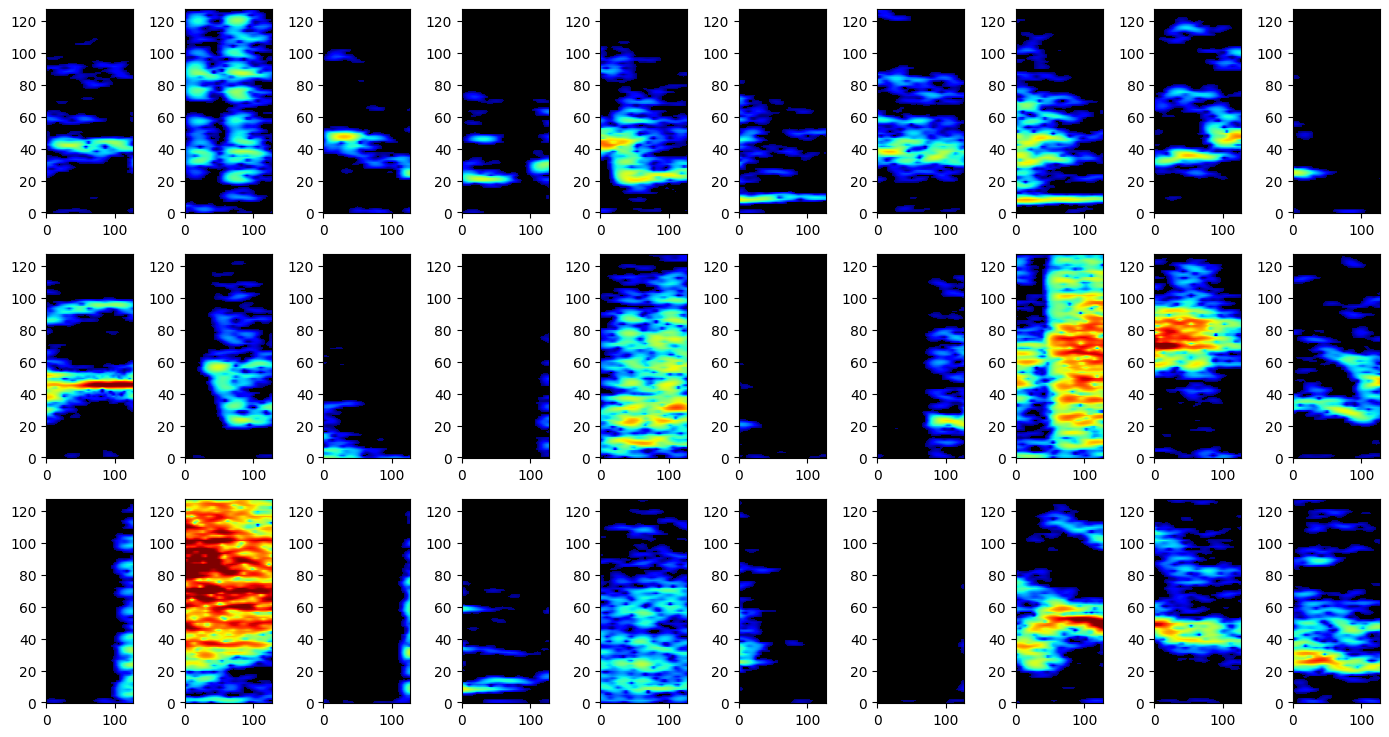

(78786, 128, 128)


In [32]:
# bi = 0 
# for bi in range(len(birdIDs)):
for bi in range(1):
    bd = birdIDs[bi]
    print(f'Processing for {bd}...')
    # change the color limit
    p['spec_min_val'] = clims[bi][0]
    p['spec_max_val'] = clims[bi][1]
    win_ms = p['nperseg']/p['fs']*1000
    hop_ms = (p['nperseg']-p['noverlap'])/p['fs']*1000
    print(f'Spectrogram window size (ms): {win_ms:.3f}')
    print(f'Spectrogram window hop (ms): {hop_ms:.3f}')
    # calculate sliding window duration
    slide_win_ms = p['win_frame'] * hop_ms
    slide_hop_ms = p['hop_frame'] * hop_ms
    slide_pad_ms = p['win_pad'] * hop_ms
    print(f'Sliding window {p["win_frame"]} spec columns, slide by {p["hop_frame"]} columns, pad by {p["win_pad"]} columns')
    print(f'Sliding window {slide_win_ms} ms, slide by {slide_hop_ms} ms, pad by {slide_pad_ms} ms')
    print(f'Sample {num_win_per} windows per syllable, {num_syl} syllables per category, total {num_win_per*num_syl} windows')
    ## given the current run a name
    run_name = f'traj_chop_{p["win_frame"]}_{p["hop_frame"]}_{p["win_pad"]}'
    print(run_name)

    # save to specific folder
    fd_save = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav', bd, 'Traj', 'Chop1')
    if not os.path.exists(fd_save):
        os.makedirs(fd_save)
    fn_h5 = os.path.join(fd_save, f'{bd}.{run_name}.chop.h5')
    fn_info = os.path.join(fd_save, f'{bd}.{run_name}.chop.info.csv')
    print(fn_h5)
    print(fn_info)

    # load the calculated spectrogram dataset
    fd_spec = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav', bd, 'Traj', spec_suffix)
    fn_spec = os.path.join(fd_spec, f'{bd}.{spec_run}.h5')
    fn_spec_info = os.path.join(fd_spec, f'{bd}.{spec_run}.info.csv')
    info_spec = pd.read_csv(fn_spec_info, delimiter=',', index_col=0)
    print(info_spec.shape)
    info_spec.head()

    # sample syllables for each category, record the row index
    print(Counter(info_spec['label']))
    idx_rd = []
    random.seed(1992)
    for s in syl:
        idx_syl = list(info_spec[info_spec['label']==s].index)
        # sample 
        sample_num = min([num_syl, len(idx_syl)])
        i_r = random.sample(idx_syl, sample_num)
        print(f'{s}: total {len(idx_syl)} syllables \t sampled {len(i_r)} syllables')
        idx_rd.append(i_r)
    # save the sampled index to disk for future use
    fn_idx = os.path.join(fd_save, f'{bd}.{run_name}.idx_rd.pkl')
    with open(fn_idx, 'wb') as f:
        pickle.dump(idx_rd, f)
    print(fn_idx)

    # sample spectrogram windows from each sampled syllable
    res_all = []
    # loop through syllable categories
    # si = 3
    for si in range(len(syl)):
        i_r = idx_rd[si]
        ## Sample spectrogram windows
        print(f'Sampling spectrogram windows from {syl[si]}...')
        with Parallel(n_jobs=48, verbose=5) as parallel:
            res = parallel(delayed(vae_goffinet.ZZ_sampleSpecWin_v1)(fn_spec, ri, num_win_per, p, resize=True) for ri in i_r)
        res_all += res

    # flatten the result
    temp = [aa[0] for aa in res_all]
    specs = [arr for sublist in temp if sublist for arr in sublist]
    df_list = [aa[1] for aa in res_all]
    info = pd.concat([df for df in df_list if not df.empty], ignore_index=True)
    print(len(specs), info.shape)

    # plot some example spectrograms
    nrow = 3
    ncol = 10
    random.seed(1118)
    plot_rd = random.sample(range(len(specs)), nrow*ncol)
    fig, axes = plt.subplots(nrow, ncol, figsize=(14, nrow*2.5))
    xmax = max([specs[ii].shape[1] for ii in plot_rd])
    for ii in range(len(plot_rd)):
        plot_i = ii//ncol
        plot_j = ii%ncol
        ax = axes[plot_i][plot_j]
        ax.imshow(specs[plot_rd[ii]], aspect='auto', cmap=custom_cmap, vmin=0, vmax=1, origin='lower')
    plt.tight_layout()
    plt.show()
    # save figure
    fn_fig = os.path.join(fd_save, f'{bd}.{run_name}.pdf')
    fig.savefig(fn_fig)

    # save padded spectrograms as h5 file 
    spec_win_all = np.stack(specs, axis=0)
    print(spec_win_all.shape)
    with h5py.File(fn_h5, 'w') as f:
        f.create_dataset('spec_win_all', data=spec_win_all)

    # also save the meta info
    mapped_spec = info_spec.iloc[info['ri'].values].reset_index(drop=True)
    # Combine both dataframes
    info_combined = pd.concat([info.reset_index(drop=True), mapped_spec], axis=1)
    info_combined.to_csv(fn_info)